In [1]:
%config Completer.use_jedi = False
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numgp as npg
import jax.numpy as jnp
from numgp.math import cartesian
from jax.random import PRNGKey


import numpy as np
import numpyro.handlers as handlers
import numpyro as npy
from numpyro.infer import Predictive

import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

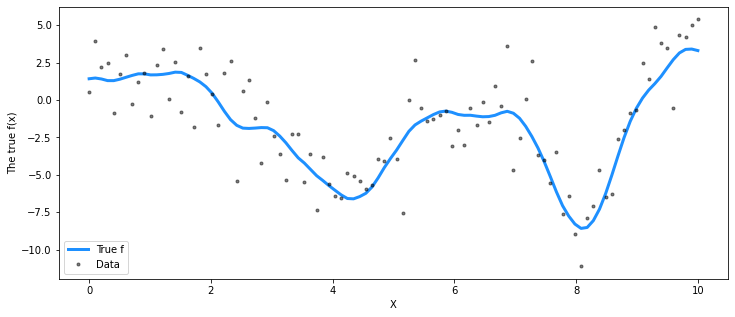

In [2]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector
Xnew = jnp.linspace(0, 20, 200)[:, None]

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * npg.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = npg.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X), cov_func(X) + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

In [3]:
def model(X, y, Xnew):
    l = npy.sample('l', dist.Gamma(2, 1))
    η = npy.sample('η', dist.HalfCauchy(5))
    σ = npy.sample('σ', dist.HalfCauchy(5))
    
    cov = η ** 2 * npg.cov.Matern52(1, l)
    gp = npg.gp.Marginal('f', cov_func=cov)
    
    y_ = gp.marginal_likelihood(X=X, y=y, noise=σ)
    _ = gp.conditional(X, Xnew)    

In [4]:
svi = npg.handler.SVIHandler(model, AutoDiagonalNormal(model), num_epochs=10000)

In [5]:
svi.fit(jnp.asarray(X), y, None, return_sites=('l', 'η', 'σ', 'f'))

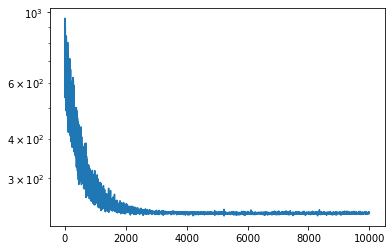

In [6]:
plt.semilogy(svi.loss)

In [7]:
svi.mean('l'), svi.mean('η'), svi.mean('σ')

(DeviceArray(1.13302521, dtype=float64),
 DeviceArray(4.03432765, dtype=float64),
 DeviceArray(1.93035774, dtype=float64))

In [8]:
marg = npg.MarginalConditional(model, 'f')

In [9]:
mu, var = marg.conditional_from_guide(svi.guide, svi.params, X, y, Xnew)

In [10]:
with handlers.seed(rng_seed=34):
    pred = npy.sample('pred', dist.MultivariateNormal(loc=mu, covariance_matrix=var).expand([200]))

In [11]:
pred.shape

(200, 200)

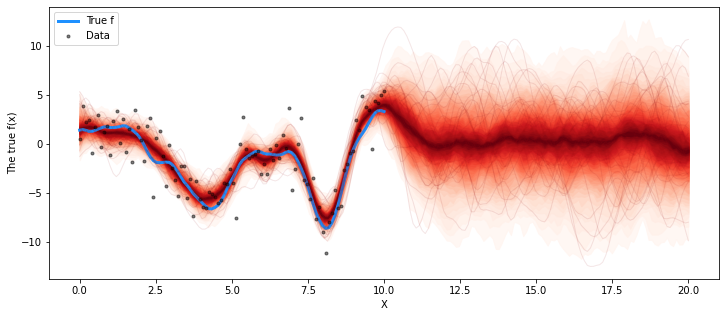

In [12]:
## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")

#plt.plot(X, svi.posterior_predictive['f'][45])
npg.util.plot_gp_dist(ax, pred, Xnew)

ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

In [13]:
mu, var = marg.conditional_from_guide(svi.guide, svi.params, X, y, Xnew, pred_noise=True)

In [17]:
with handlers.seed(rng_seed=34):
    pred_noise = npy.sample('pred_noise', dist.MultivariateNormal(loc=mu, covariance_matrix=var).expand([2000]))

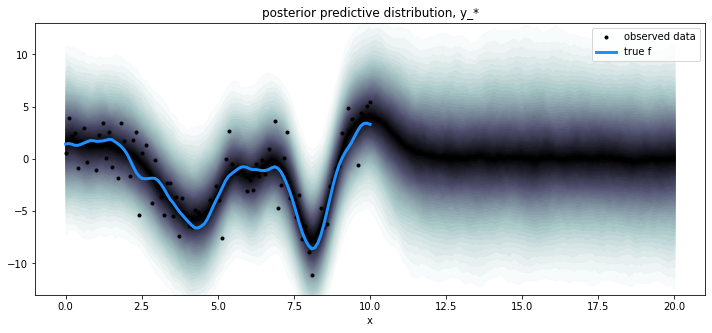

In [30]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# posterior predictive distribution
npg.util.plot_gp_dist(ax, pred_noise, Xnew, plot_samples=False, palette="bone_r")

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
#plt.plot(Xnew, pred_noise[20:30, :].T, "co", ms=2, label="Predicted data")

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("posterior predictive distribution, y_*")

plt.legend();

In [24]:
pred_noise[300,:].shape

(200,)